In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import base64
from IPython.display import HTML
from datetime import datetime


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def prepare_data(data, n_steps, n_features):
    X, y = [], []
    scaler = MinMaxScaler()

    # Considerando que as últimas n_features colunas são as features e a primeira coluna 'value' é o target
    data_scaled = scaler.fit_transform(data)

    for i in range(len(data) - n_steps):
        # X: janela de 'n_steps' contendo 'n_features' features
        # y: valor de 'value' no timestep seguinte
        X.append(data_scaled[i:i + n_steps, -n_features:])
        y.append(data_scaled[i + n_steps, 0])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Carregando seus dados
data = pd.read_csv('/content/sample_data/dados_originais (6).csv')
#Supondo que você tenha 4 features na ordem correta e 'value' como a primeira coluna
data_array = data[['value']].to_numpy()

n_steps = 30
n_features = 1
X, y, scaler = prepare_data(data_array, n_steps, n_features)

In [5]:
# Visualização dos resultados pelo Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['timestamp_dt'], y=data['value'], mode='lines', name='Dados Originais', marker=dict(color='blue')))
fig.update_layout(title='Dados Originais e Outliers', xaxis_title='Data e Hora', yaxis_title='Valor', xaxis=dict(type='date'))
fig.show()

In [6]:
def split_data(X, y, train_ratio=0.5, validation_ratio=0.15):
    total_samples = len(X)
    train_size = int(total_samples * train_ratio)
    validation_size = int(total_samples * validation_ratio)

    # Dados de treinamento
    X_train, y_train = X[:train_size], y[:train_size]
    # Dados de validação
    X_val, y_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size]
    # Dados de teste
    X_test, y_test = X[train_size + validation_size:], y[train_size + validation_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Dividindo os dados
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate

# Construção do modelo
input_layer = Input(shape=(n_steps, n_features))
lstm_out = LSTM(50, return_sequences=True)(input_layer)
attention = Attention()([lstm_out, lstm_out])  # usando lstm_out duas vezes para auto atenção
attention_output = Concatenate()([lstm_out, attention])
flat_output = tf.keras.layers.Flatten()(attention_output)
dense_layer = Dense(50, activation='relu')(flat_output)
output_layer = Dense(1)(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=2)

# Avaliação do modelo no conjunto de teste
test_loss = model.evaluate(X_test, y_test)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 30, 50)               10400     ['input_2[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 30, 50)               0         ['lstm_1[0][0]',              
                                                                     'lstm_1[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate  (None, 30, 100)              0         ['lstm_1[0][0]',          

49/49 [==============================] - 2s 10ms/step


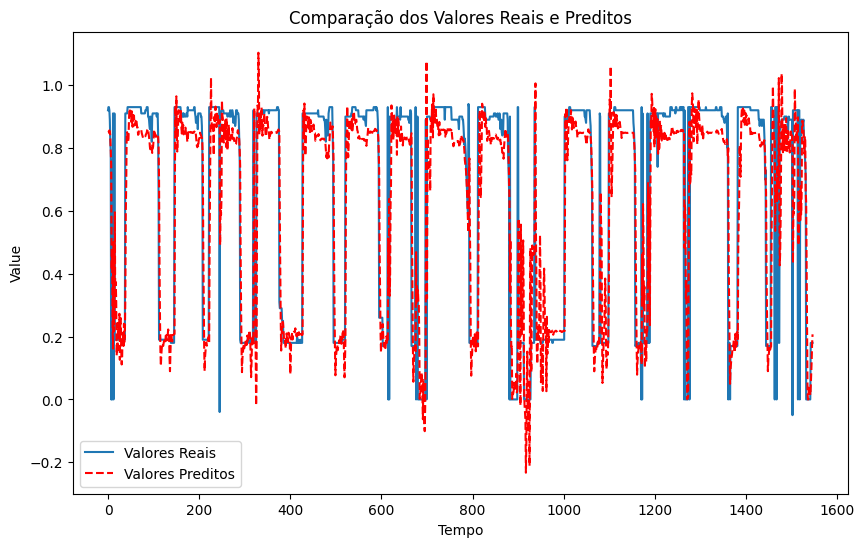

In [10]:
import matplotlib.pyplot as plt

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Invertendo a normalização para plotar os dados reais e os preditos
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler.inverse_transform(y_pred)

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_real, label='Valores Reais')
plt.plot(y_pred_real, label='Valores Preditos', linestyle='--', color= 'red')
plt.title('Comparação dos Valores Reais e Preditos')
plt.xlabel('Tempo')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
model.save('modelo.h5')  # Salva o em formato HDF5
from google.colab import files

files.download('meu_modelo_lstm.h5')
